# Notebook project about testing SAM to segment Cardiac MRI scans

## Google Colab configuration

In [1]:
!git clone https://github.com/Silvano315/Med-Physics.git

Cloning into 'Med-Physics'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 13), reused 23 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 20.37 KiB | 10.18 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
# change working directory

import os

os.chdir("Med-Physics")
os.getcwd()

'/content/Med-Physics'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copy your Kaggle API to /root/.config/kaggle and /root/.kaggle/kaggle.json

os.makedirs('/root/.kaggle', exist_ok = True)

!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.config/kaggle.json
!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.kaggle/kaggle.json

In [5]:
# Install requirements

!pip install segment_anything

## Import Libraries

In [ ]:
# If you're running this repository LOCALLY, RUN this cell:

import os
os.chdir("..")
os.getcwd()

'/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics'

In [27]:
# Import libraries

import kaggle
import urllib.request
from pathlib import Path
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor
import h5py
import pandas as pd
import re
from pathlib import Path
from ipywidgets import interact
from scipy.ndimage import binary_fill_holes
from typing import List, Dict, Optional

## Setup and Configuration

In [7]:
# Set up device to use

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [8]:
# Create directories

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

## Download dataset

In [9]:
def download_kaggle_dataset(dataset_name : str = None, kaggle_url : str = None):
    """
    Download ACDC dataset from Kaggle using Kaggle API.
    Requires:
    1. Kaggle account
    2. API token (kaggle.json) in ~/.kaggle/
    3. kaggle package installed: pip install kaggle
    """

    data_dir = Path('data')
    data_dir.mkdir(exist_ok=True)

    print(f"Downloading {dataset_name} dataset from Kaggle...")
    try:
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(
            kaggle_url,
            path=data_dir,
            unzip=True
        )
        print("Dataset downloaded and extracted successfully!")

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("\nPlease ensure you have:")
        print("1. Created a Kaggle account")
        print("2. Generated an API token from https://www.kaggle.com/settings")
        print("3. Placed kaggle.json in ~/.kaggle/")
        print("4. Set appropriate permissions: chmod 600 ~/.kaggle/kaggle.json")
        raise

In [10]:
# Download ACDC dataset from Kaggle using API key

download_kaggle_dataset(dataset_name="ACDC", kaggle_url='anhoangvo/acdc-dataset')

Dataset URL: https://www.kaggle.com/datasets/anhoangvo/acdc-dataset
Dataset downloaded and extracted successfully!


## Cardiac MRI Segmentation with SAM - Exploratory Analysis

In [11]:
# Set up SAM Model

def setup_sam():
    """Initialize and load SAM model."""

    sam_checkpoint = "sam_vit_b_01ec64.pth"
    checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

    if not os.path.exists(sam_checkpoint):
        print("Downloading SAM checkpoint...")
        urllib.request.urlretrieve(checkpoint_url, sam_checkpoint)

    model_type = "vit_b"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=DEVICE)

    return sam

In [12]:
sam = setup_sam()
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Data Loading & Preprocessing

In [13]:
def list_h5_files(data_dir: Path, subset: str = 'training'):
    """
    List all H5 files in the specified directory.

    Args:
        data_dir: Base directory containing the dataset
        subset: 'training' or 'testing'

    Returns:
        List of paths to H5 files
    """
    if 'training' in subset:
        pattern = f"**/*_{subset}/*.h5"
    else:
        pattern = f"**/*_{subset}_*/*.h5"

    return list(data_dir.glob(pattern))

In [14]:
training_volumes_files = list_h5_files(data_dir, 'training_volumes')
training_slices_files = list_h5_files(data_dir, 'training_slices')
testing_volumes_files = list_h5_files(data_dir, 'testing')

print(f"Found {len(training_slices_files)} training slises \
and {len(training_volumes_files)} training volumes files \
and {len(testing_volumes_files)} testing volumes files")

Found 1912 training slises and 200 training volumes files and 100 testing volumes files


In [15]:
def create_dataset_info(file_lists: Dict[str, List[Path]]) -> pd.DataFrame:
    """
    Create a DataFrame with information about the dataset files.

    Args:
        file_lists: Dictionary with keys 'training_volumes', 'training_slices', 'testing_volumes'
                   and corresponding lists of Path objects

    Returns:
        DataFrame with columns: patient_id, frame, slice (if applicable), type, path
    """
    all_data = []

    pattern = r'patient(\d+)_frame(\d+)(?:_slice_(\d+))?'

    for data_type, files in file_lists.items():
        for file_path in files:
            match = re.search(pattern, file_path.name)
            if match:
                patient_id = match.group(1)
                frame = match.group(2)
                slice_num = match.group(3)

                data_entry = {
                    'patient_id': int(patient_id),
                    'frame': int(frame),
                    'slice': int(slice_num) if slice_num else None,
                    'type': data_type,
                    'path': str(file_path)
                }
                all_data.append(data_entry)

    df = pd.DataFrame(all_data)
    df = df.sort_values(['patient_id', 'frame', 'slice'])

    return df

In [16]:
file_lists = {
        'training_volumes': training_volumes_files,
        'training_slices': training_slices_files,
        'testing_volumes': testing_volumes_files
    }

dataset_df = create_dataset_info(file_lists)
print("\nDataset Overview:")
dataset_df


Dataset Overview:


patient_id  frame  slice             type  \
1107           1      1    0.0  training_slices   
1921           1      1    1.0  training_slices   
201            1      1    2.0  training_slices   
562            1      1    2.0  training_slices   
207            1      1    3.0  training_slices   
...          ...    ...    ...              ...   
2151         148     10    NaN  testing_volumes   
2121         149      1    NaN  testing_volumes   
2155         149     12    NaN  testing_volumes   
2132         150      1    NaN  testing_volumes   
2208         150     12    NaN  testing_volumes   

                                                   path  
1107  data/ACDC_preprocessed/ACDC_training_slices/pa...  
1921  data/ACDC_preprocessed/ACDC_training_slices/pa...  
201   data/ACDC_preprocessed/ACDC_training_slices/pa...  
562   data/ACDC_preprocessed/ACDC_training_slices/pa...  
207   data/ACDC_preprocessed/ACDC_training_slices/pa...  
...                                                 ...  
2151  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2121  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2155  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2132  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2208  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  

[2212 rows x 5 columns]

In [17]:
print("Dataset Statistics:")
print(f"Total files: {len(dataset_df)}")
print("\nFiles per type:")
print(dataset_df['type'].value_counts())
print("\nUnique patients:", dataset_df['patient_id'].nunique())

Dataset Statistics:
Total files: 2212

Files per type:
type
training_slices     1912
training_volumes     200
testing_volumes      100
Name: count, dtype: int64

Unique patients: 150


In [18]:
def load_h5_data(file_path: str):
    """
    Load data from H5 file.

    Args:
        file_path: Path to H5 file

    Returns:
        Dictionary containing image and mask data
    """
    with h5py.File(file_path, 'r') as f:
        print(f"Available keys in {Path(file_path).name}:", list(f.keys()))

        data = {}
        if 'image' in f:
            data['image'] = f['image'][:]
        if 'label' in f:
            data['label'] = f['label'][:]
        if 'scribble' in f:
            data['scribble'] = f['scribble'][:]

        return data

In [19]:
if training_volumes_files:
        sample_data = load_h5_data(training_volumes_files[0])

sample_data['image'], sample_data['label'], sample_data['scribble']

Available keys in patient016_frame01.h5: ['image', 'label', 'scribble']


(array([[[0.00998265, 0.00998265, 0.00998265, ..., 0.00998265,
          0.00998265, 0.00998265],
         [0.00998265, 0.00998265, 0.00998265, ..., 0.00998265,
          0.00998265, 0.00998265],
         [0.00998265, 0.00998265, 0.00998265, ..., 0.00998265,
          0.00998265, 0.00998265],
         ...,
         [0.00998265, 0.01497397, 0.01497397, ..., 0.00998265,
          0.00998265, 0.00998265],
         [0.00998265, 0.01497397, 0.01497397, ..., 0.00998265,
          0.00998265, 0.00998265],
         [0.00998265, 0.01497397, 0.01497397, ..., 0.00998265,
          0.00998265, 0.00998265]],
 
        [[0.00499132, 0.00499132, 0.00499132, ..., 0.00499132,
          0.00499132, 0.00499132],
         [0.00499132, 0.00499132, 0.00499132, ..., 0.00499132,
          0.00499132, 0.00499132],
         [0.00499132, 0.00499132, 0.00499132, ..., 0.00499132,
          0.00499132, 0.00499132],
         ...,
         [0.00499132, 0.00998265, 0.00998265, ..., 0.01497397,
          0.00998265, 0.

### Visualize 2D-3D MRI images with labels and scribbles

In [20]:
def plot_slice_with_mask(image, label, scribble=None, title="Cardiac MRI Slice"):
    """
    Plot a cardiac MRI slice with optional overlay of the mask.

    Args:
        image: 2D numpy array of the image
        label: 2D numpy array of the label image
        scribble: Optional 2D numpy array of the scribble mask
        title: Plot title
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image, cmap='gray')
    if scribble is not None:
        plt.imshow(scribble, alpha=0.3, cmap='jet')
        plt.title("With Scribble")
    else:
        plt.title("No Scribble")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, alpha=0.3, cmap='jet')
    plt.title("With Label")
    plt.axis('off')

    plt.suptitle(f"{title}", y=1.02)
    plt.tight_layout()
    plt.show()

Available keys in patient030_frame01_slice_7.h5: ['image', 'label', 'scribble']


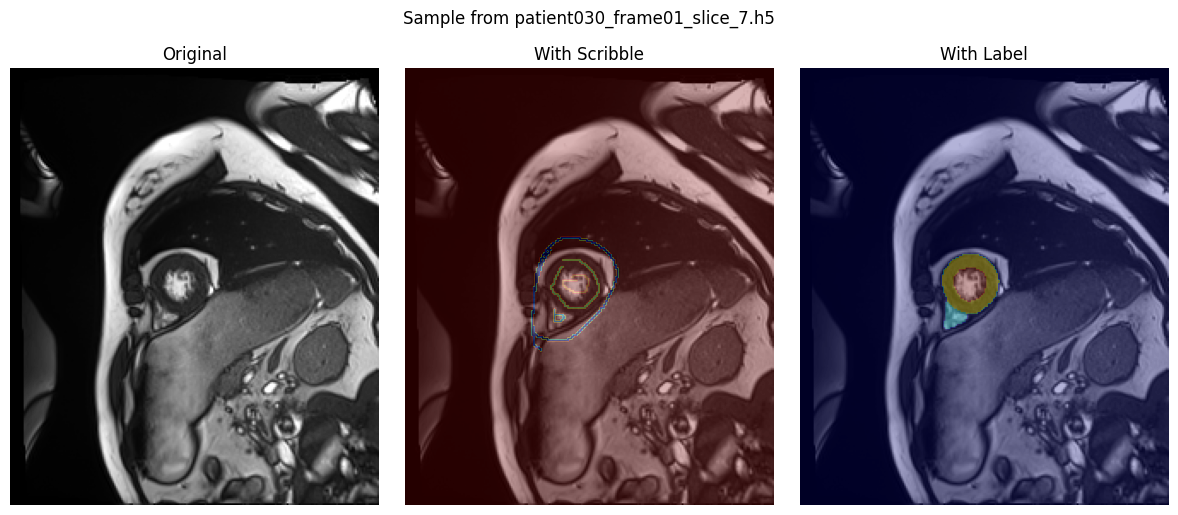

In [21]:
if training_slices_files:
  sample = np.random.randint(0, len(training_slices_files))
  sample_data = load_h5_data(training_slices_files[sample])

  if len(sample_data['image'].shape) == 3:
      middle_slice = sample_data['image'].shape[2] // 2
      image_slice = sample_data['image'][:, :, middle_slice]
      mask_slice = sample_data['scribble'][:, :, middle_slice] if 'scribble' in sample_data else None
  else:
      image_slice = sample_data['image']
      mask_slice = sample_data['scribble'] if 'scribble' in sample_data else None

plot_slice_with_mask(image_slice, sample_data['label'], mask_slice,
                      f"Sample from {Path(training_slices_files[sample]).name}")

In [22]:
def plot_volume_slices(
    volume: np.ndarray,
    label: np.ndarray,
    scribble: Optional[np.ndarray] = None,
    start_slice: Optional[int] = None,
    num_slices: int = 3,
    step: Optional[int] = None,
    title: str = "Cardiac MRI Volumes"
) -> None:
    """
    Plot multiple slices from a 3D volume, optionally with overlayed labels and scribbles.

    Args:
      - volume (np.ndarray): The 3D volume to display, with shape (depth, height, width).
      - label (np.ndarray): The 3D label mask to overlay, with shape (depth, height, width).
      - scribble (Optional[np.ndarray]): An optional 3D scribble mask to overlay, with shape (depth, height, width).
      - start_slice (Optional[int]): The starting slice index. If None, the function centers the slices.
      - num_slices (int): The number of slices to display.
      - step (Optional[int]): Step size between slices. Default is 1.
      - title (str): The title for the entire figure.
    """
    if start_slice is None:
        middle = volume.shape[0] // 2
        start_slice = middle - (num_slices // 2)

    if step is None:
        step = 1

    rows = 3 if scribble is not None else 2

    fig, axes = plt.subplots(rows, num_slices, figsize=(5 * num_slices, 5 * rows))
    for i in range(num_slices):
        slice_idx = start_slice + (i * step)
        axes[0,i].imshow(volume[slice_idx], cmap='gray')
        axes[0,i].set_title(f'Slice {slice_idx}', fontsize=20)
        axes[0,i].axis('off')

        axes[1,i].imshow(volume[slice_idx], cmap='gray')
        axes[1,i].imshow(label[slice_idx], alpha = 0.3, cmap='jet')
        axes[1,i].set_title('With Label', fontsize=20)
        axes[1,i].axis('off')

        if scribble is not None:
          axes[2,i].imshow(volume[slice_idx], cmap='gray')
          axes[2,i].imshow(scribble[slice_idx], alpha = 0.3, cmap='jet')
          axes[2,i].set_title('With Scribble', fontsize=20)
          axes[2,i].axis('off')

    plt.suptitle(f'{title}', fontsize=28)
    plt.tight_layout()
    plt.show()

Available keys in patient012_frame01.h5: ['image', 'label', 'scribble']


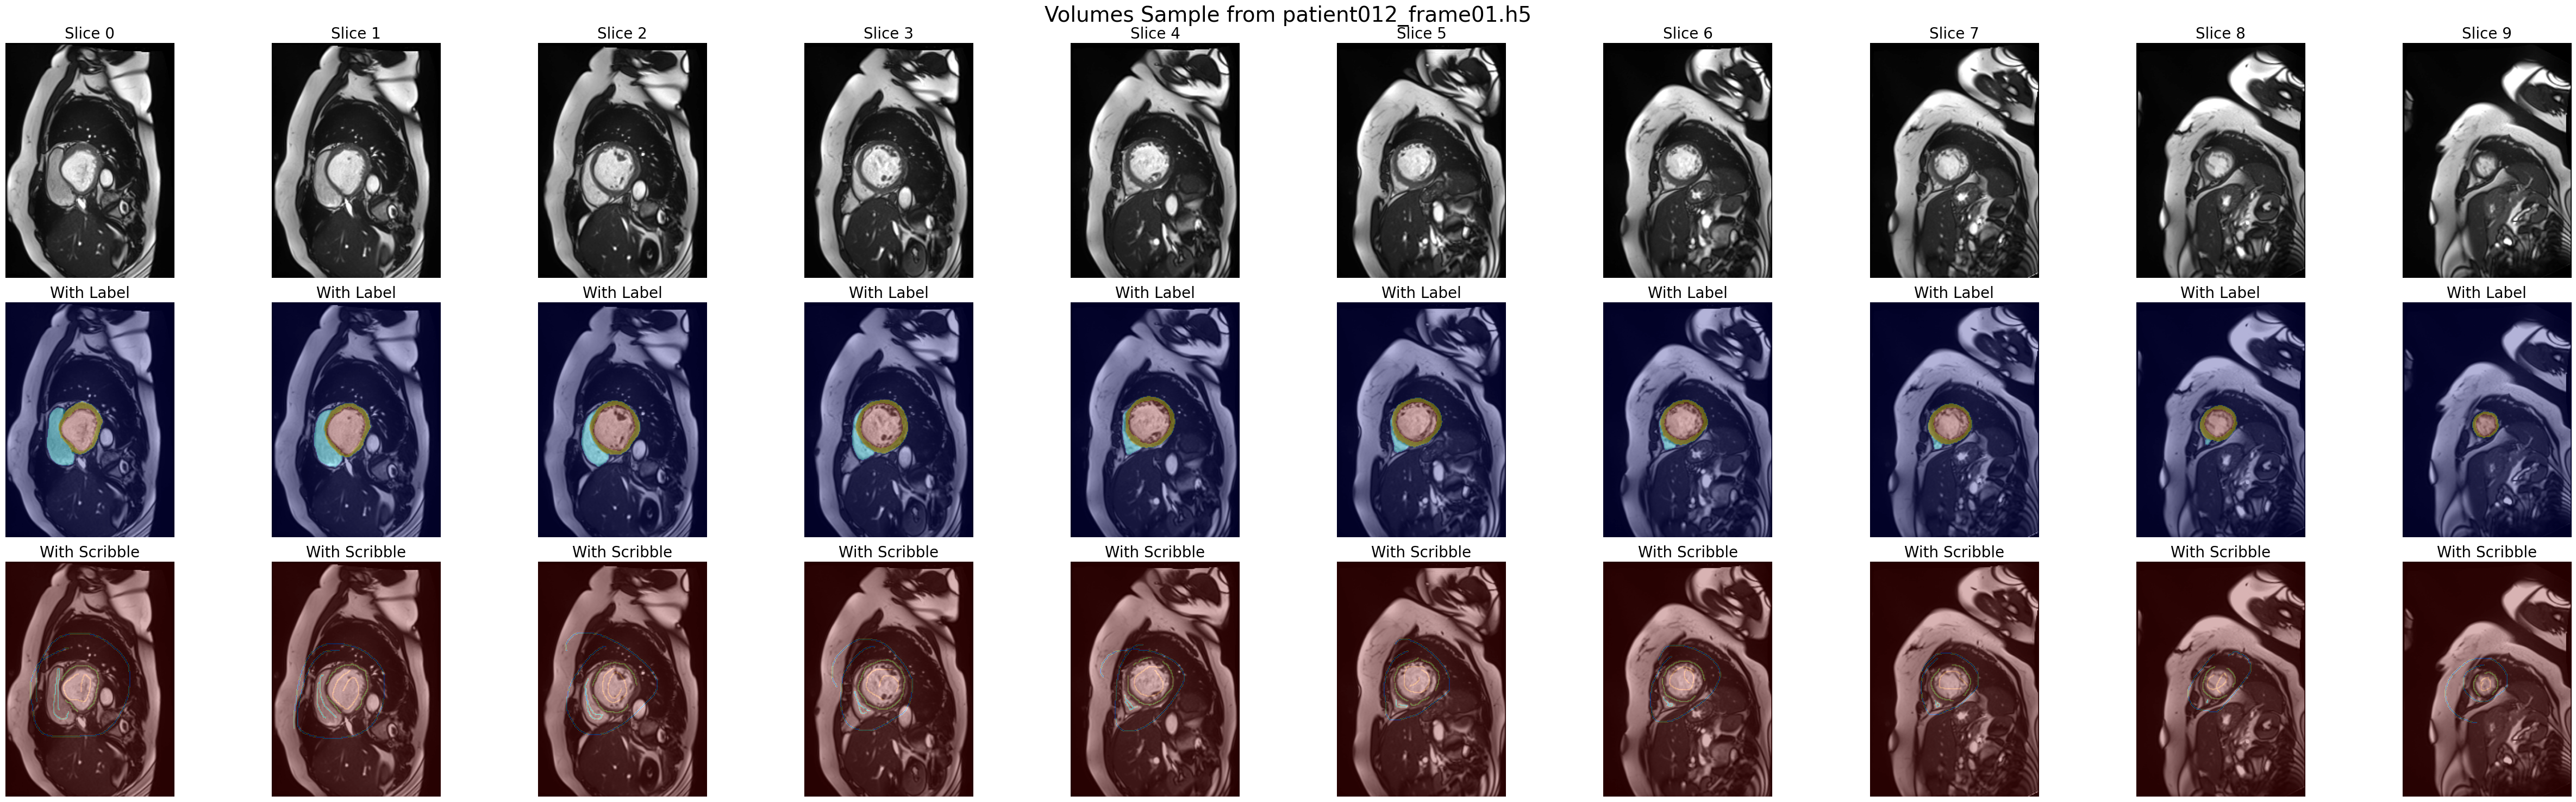

In [23]:
if training_volumes_files:
  sample = np.random.randint(0, len(training_volumes_files))
  sample_data = load_h5_data(training_volumes_files[sample])

plot_volume_slices(sample_data['image'], label = sample_data['label'],
                   scribble = sample_data['scribble'] if 'scribble' in sample_data else None,
                   start_slice = 0,
                   num_slices = sample_data['image'].shape[0],
                   title = f"Volumes Sample from {Path(training_volumes_files[sample]).name}")

In [24]:
def volume_slider(volume: np.ndarray, label: np.ndarray):
    """
    Create an interactive slider to navigate the volume with the label side by side.

    Args:
      - volume (np.ndarray): The 3D volume to be displayed (depth, height, width).
      - label (np.ndarray): The 3D label mask corresponding to the volume.
    """
    def view_slice(slice_idx: int):
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(volume[slice_idx], cmap='gray')
        plt.title(f'Volume - Slice {slice_idx}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(volume[slice_idx], cmap='gray')
        plt.imshow(label[slice_idx], alpha=0.3, cmap='jet')
        plt.title(f'Volume con Label - Slice {slice_idx}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    interact(view_slice, slice_idx=(0, volume.shape[0] - 1))

In [25]:
volume_slider(sample_data['image'], sample_data['label'])

interactive(children=(IntSlider(value=4, description='slice_idx', max=9), Output()), _dom_classes=('widget-int…

## SAM with Zero-Shot Generalization

In [26]:
def prepare_image(image):
  """Prepare medical image for SAM."""
  # Normalize to [0, 255]
  image_norm = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

  # Convert to RGB by repeating the channel
  image_rgb = np.stack([image_norm] * 3, axis=2)
  return image_rgb

In [44]:
def get_internal_points(scribble, threshold=0.5):
    """
    Takes the internal black dots from the scribble.
    """
    scribble_min = np.min(scribble)
    scribble_max = np.max(scribble)

    if scribble_min == scribble_max:
        scribble = np.full_like(scribble, 255, dtype=np.uint8)
    else:
        scribble = ((scribble - scribble_min) / (scribble_max - scribble_min) * 255).astype(np.uint8)

    binary_scribble = scribble <= threshold

    filled_scribble = binary_fill_holes(binary_scribble)

    points_y, points_x = np.where(filled_scribble)
    points = np.stack([points_x, points_y], axis=1)

    if len(points) > 50:
        indices = np.random.choice(len(points), 10, replace=False)
        points = points[indices]

    return points

Available keys in patient081_frame01_slice_9.h5: ['image', 'label', 'scribble']


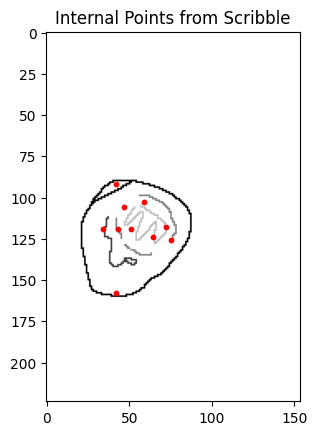

In [53]:
sample = np.random.randint(0, len(training_slices_files))
sample_data = load_h5_data(training_slices_files[sample])
scribble = sample_data['scribble']
internal_points = get_internal_points(scribble)
plt.imshow(scribble, cmap='gray')
plt.scatter(internal_points[:, 0], internal_points[:, 1], color='red', s=10)
plt.title("Internal Points from Scribble")
plt.show()

In [31]:
sam = setup_sam()
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [54]:
image_rgb = prepare_image(sample_data['image'])
predictor.set_image(image_rgb)

input_points = None
input_labels = None

internal_points = get_internal_points(sample_data['scribble'])
input_points = internal_points
input_labels = np.ones(len(internal_points))

boxes = None
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    box=boxes[0] if boxes is not None else None,
    multimask_output=True)

In [33]:
def visualize_results(image, masks, scores, title="SAM Segmentation"):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image, cmap='gray')
    if len(scores) > 0:
        best_mask = masks[scores.argmax()]
        plt.imshow(best_mask, alpha=0.5, cmap='jet')
    plt.title(f"Best Mask (score: {scores.max():.2f})")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    for mask, score in zip(masks, scores):
        color = np.random.rand(3)
        plt.imshow(mask, alpha=0.3 * (score > 0.9), cmap='jet')
    plt.title("All Masks")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

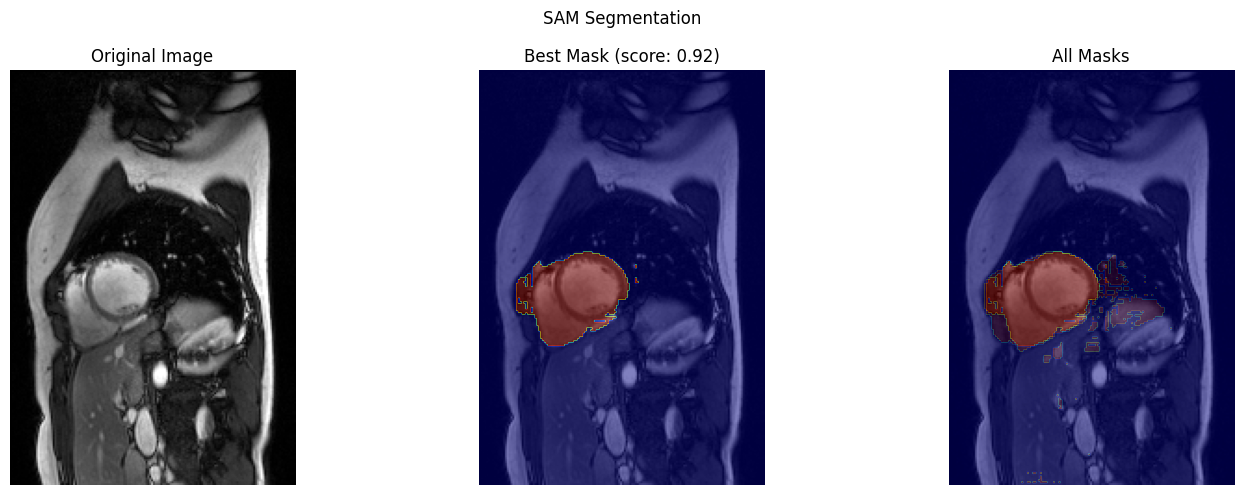

In [55]:
visualize_results(sample_data['image'], masks, scores)

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

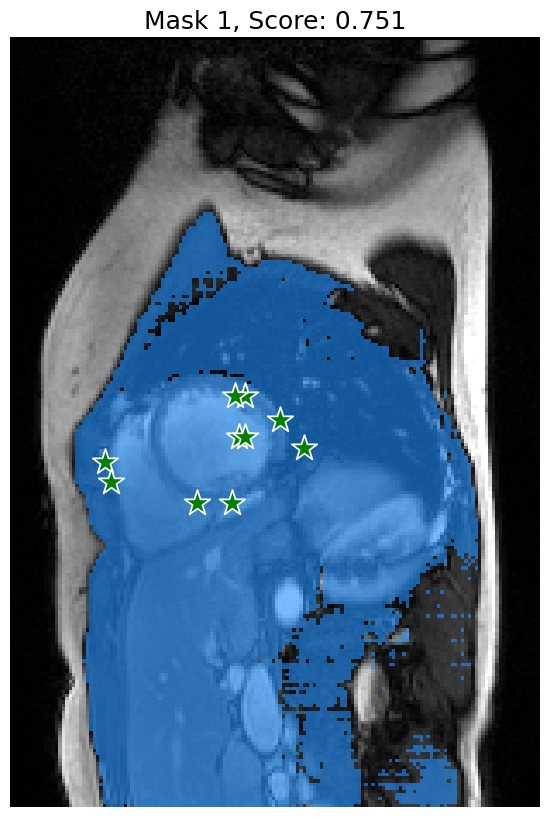

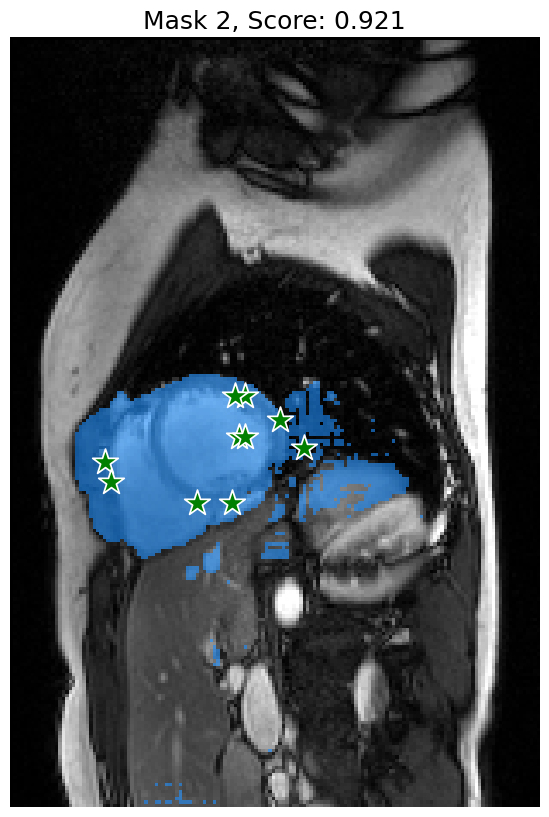

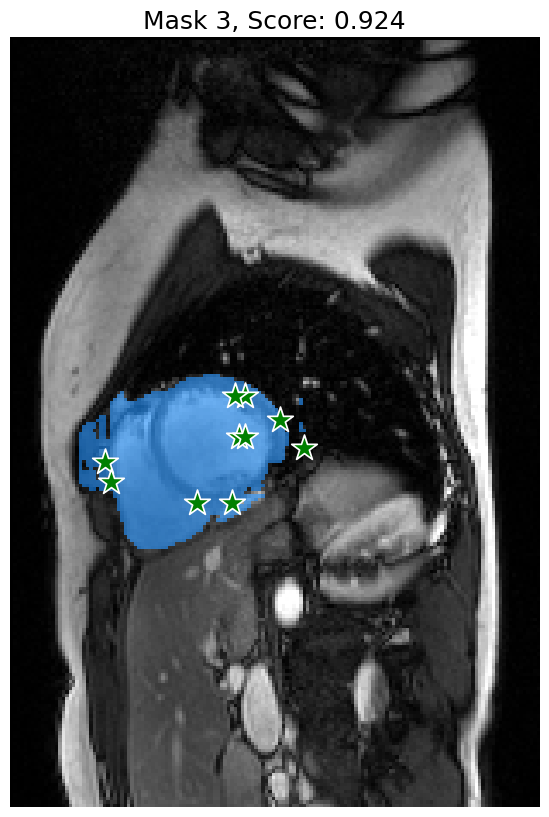

In [56]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(sample_data['image'], cmap='gray')
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

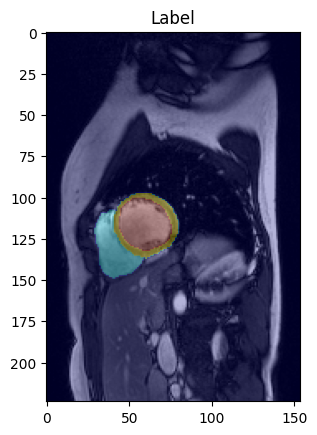

In [57]:
plt.title("Label")
plt.imshow(sample_data['image'], cmap='gray')
plt.imshow(sample_data['label'], alpha = 0.3, cmap='jet')

## SAM Fine-Tuning

In [ ]:
def get_points_for_training(scribble, label, n_points_per_class=10):
    """
    Points for SAM training considering only the internal classes.
    
    Args:
        scribble: numpy array with values 0 (boundary) e 4 (background)
        label: numpy array with different classes
        n_points_per_class: number of points to be drawn for each class
    
    Returns:
        points: numpy array of points (x, y)
        point_labels: original label for each point
    """
    classes = np.unique(label)[1:]  
    internal_points = []
    point_classes = []
    
    for class_id in classes:
        valid_region = (label == class_id) & (scribble == 4)
        y_coords, x_coords = np.where(valid_region)
        
        if len(x_coords) > 0:
            n_points = min(n_points_per_class, len(x_coords))
            idx = np.random.choice(len(x_coords), n_points, replace=False)
            points = np.column_stack([x_coords[idx], y_coords[idx]])
            
            internal_points.append(points)
            point_classes.extend([class_id] * n_points)
    
    if internal_points:
        all_points = np.vstack(internal_points)
        point_labels = np.array(point_classes)
    else:
        all_points = np.array([])
        point_labels = np.array([])
    
    return all_points, point_labels

def visualize_points(image, points, point_labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    
    classes = np.unique(point_labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    
    for class_id, color in zip(classes, colors):
        mask = point_labels == class_id
        plt.plot(points[mask, 0], points[mask, 1], '.', 
                color=color, label=f'Class {class_id}', markersize=10)
    
    plt.legend()
    plt.axis('off')
    plt.title('Points per Class')
    plt.show()

In [ ]:
points, point_labels = get_points_for_training(scribble, sample_data['label'], n_points_per_class = 1)
visualize_points(sample_data['image'], points, point_labels)

In [ ]:
plt.title("Label")
plt.imshow(sample_data['image'], cmap='gray')
plt.imshow(sample_data['label'], alpha = 0.3, cmap='jet')
plt.axis('off')
plt.show()